# Time Series forecasting : TESLA stock price forecasting

## Topic

In this notebook I will be using  the TESLA stock prices for the last year to try and forecast the said stock prices for the following month. I downloaded the dataset from the online Yahoo stock price publisher. The dataset contains the time stamps of the operations and their volume, the opening , highest, lowest, and closing price of the stocks. I will only be using the opening prices for my study and I will use three forecasting models: an ETS model, an ARIMA model and a Prophet model.

## Objectives

- Decompose and understand the features of the time series
- Make forecasts for the month of January 2023

## Summary

- Importing Libraries
- The Dataset
- Dataviz
- ETS model : Holt Winter's Seasonal method
- ARIMA model : seasonal ARIMA
- Prophet model
- Comparing models performance
- Making forecasts
- Conclusion
- References

## Importing Libraries

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Statistics
import statsmodels.api as sm
# ETS models
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
# checking for stationarity
from statsmodels.tsa.stattools import adfuller
# transform the target variable to resemble a normal distribution
# ARIMA model
from pmdarima import auto_arima
# for forecasting
from prophet import Prophet
# Models validation
from sklearn.metrics import mean_squared_error,mean_absolute_error
# Calculate the Akaike Information Criterion
from astropy.stats.info_theory import akaike_info_criterion_lsq
# Autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf
# For date time
from datetime import datetime

# The Dataset

In [2]:
ts = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Tesla Stock\TSLA.csv', sep =",")
ts.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-30,353.776672,365.183319,351.049988,356.779999,356.779999,47040900
1,2021-12-31,357.813324,360.666656,351.529999,352.260010,352.260010,40733700
2,2022-01-03,382.583344,400.356659,378.679993,399.926666,399.926666,103931400
3,2022-01-04,396.516663,402.666656,374.350006,383.196655,383.196655,100248300
4,2022-01-05,382.216675,390.113342,360.336670,362.706665,362.706665,80119800


Now that I have imported the dataset, I can see the features it contains which are:
- the date of the transactions
- the opening price at which the day opens
- high which is the maximum price during that day
- low which is the lowest price during that day
- close which is the close price adjusted for splits
- Adj Close - adjusted close price adjusted for both dividends and splits.
- Volume - the number of shares that changed hands during a given day

In this notebook I chose to track the evolution and forecast the opening price of Tesla stocks, so I will get rid of the other features for now.

In [3]:
ts = ts.drop(columns=["High","Low","Close","Adj Close","Volume"], axis =1)
ts.head()

,Date,Open
0,2021-12-30,353.776672
1,2021-12-31,357.813324
2,2022-01-03,382.583344
3,2022-01-04,396.516663
4,2022-01-05,382.216675


In [4]:
ts["Date"].dtype

dtype('O')

In [5]:
ts["Date"] = pd.to_datetime(ts["Date"])

In [6]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    252 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


In the above I just transformed the date column to become datetime so I use it in the analysis. I see that the dataset is complete and that there are no missing value.

In [7]:
ts.Date.min()

Timestamp('2021-12-30 00:00:00')

In [8]:
ts.Date.max()

Timestamp('2022-12-29 00:00:00')

I see here that this data has been collected over the last year, with the first observation being on the 30th of December 2021 and the latest being yesterday the 29th of December 2022.

In [9]:
# Sort the series
ts.sort_values(by='Date', inplace = True)

In [10]:
# reset the index
ts.set_index('Date', inplace=True)

In [11]:
ts.shape

(252, 1)

Here I reset the index so it would be the actual timestamp, and checked the shape of the DS which is 1 column (the target feature opening price) and 252 rows corresponding to 252 days of the year 2022, I reckon that the reason why several days are missing is because the stock market is closed on weekends and holidays.

# Dataviz

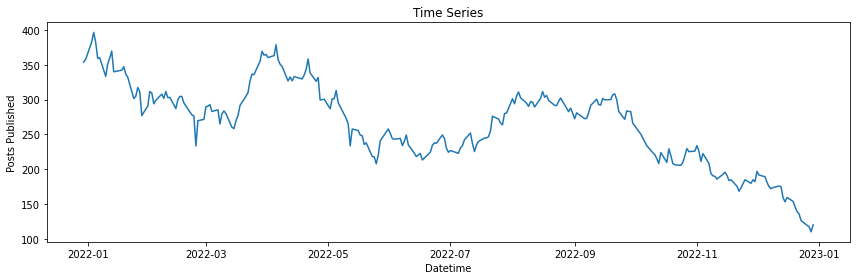

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(ts)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

At first glance, the time series seems to have a downward trend and somewhat a weekly seasonality, I'm not sure yet so let's use the decompostion plot to gain more insight.

## Decomposition plot

In [13]:
ts = ts.resample('D').sum()

In [14]:
ts.shape

(365, 1)

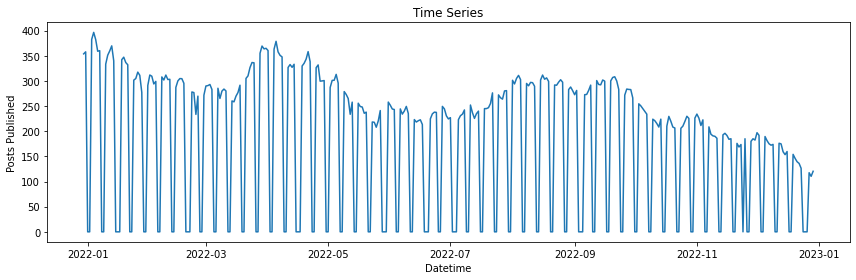

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(ts)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

In this part I resampled the data to make it daily and contain the 365 days of the year, and used the sum option to sum up the value of the day, what happened here is that function resample created the missing days of the year and put in as their target value 0. The result is a highly seasonal time seies.

In [16]:
decomposition = sm.tsa.seasonal_decompose(ts)

<AxesSubplot:title={'center':'error'}, xlabel='Date'>

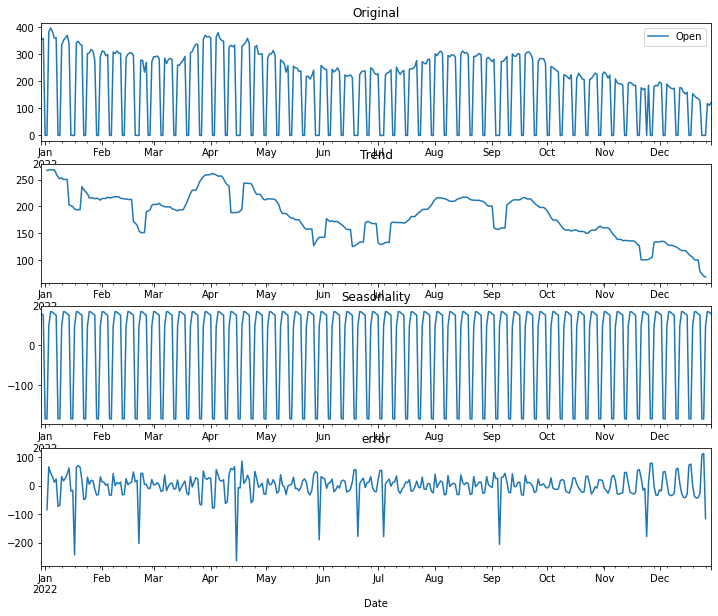

In [17]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
ts.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='error', ax=axes[3])

From the decomposition plot I can make some assumptions about the data, first of all is that it has slight downtrend, and second is that it has a weekly seasonality and a somewhat constant error. This suggests to me that when I build an ETS model, I should use and additive trend, additive seasonality because this latter doesn't grown of diminish in magnitude over time, and an additive method for the error as well because it looks constant over time.

In [18]:
train = ts.loc[:'2022-11-30']
test = ts.loc['2022-12-01':]

So here I devided the train and test sets, I chose the last month or 30 days as the period I want to forecast for.

# ETS models : Holt Winter's Seasonal Method

In [19]:
ep = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add').fit()

In [20]:
ep.summary()

Dep. Variable:,Open,No. Observations:,336
Model:,ExponentialSmoothing,SSE,801126.438
Optimized:,True,AIC,2634.959
Trend:,Additive,BIC,2676.947
Seasonal:,Additive,AICC,2636.089
Seasonal Periods:,7,Date:,"Thu, 05 Jan 2023"
Box-Cox:,False,Time:,19:26:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1119804,alpha,True
smoothing_trend,0.0002351,beta,True


The Holt Winters' seasonal method has an Akaike Information Criterion of 2634, its trend and seasonality are added additevely and the seasonal period is 7.

In [21]:
ep_pred = ep.forecast(len(test))

In [22]:
ep_rmse =  mean_squared_error(test, ep_pred, squared=False)
ep_rmse

44.87345422539058

In [23]:
ep_mae = mean_absolute_error(test, ep_pred)
ep_mae

33.16284884234365

The RMSE and MAE seem low enough although they cannot tell us much , they need to be compared against the other models'.

In [24]:
# function to plot the forecast

def plot_forecast(forecast, model):
    plt.figure(figsize=(12,4))
    plt.plot(train, label='Training')
    plt.plot(test, label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model}')
    plt.legend()
    plt.tight_layout()
    plt.show()

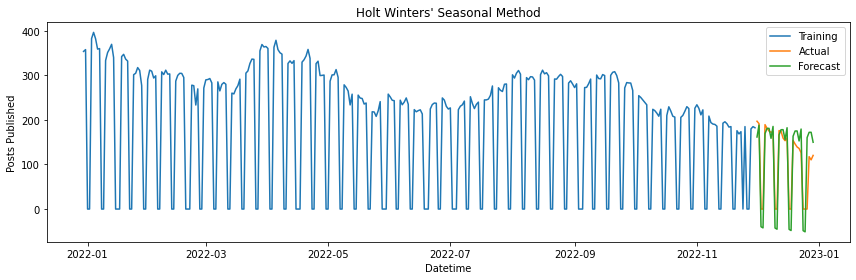

In [25]:
plot_forecast(ep_pred, "Holt Winters' Seasonal Method")

The forecast plot shows a fairly good job done by Holt Winters' model, it aligns very well with the observed values.

# ARIMA Models : Seasonal ARIMA

Ok, since the time series has seasonality and trend, I will be using the enhanced ARIMA, SARIMA which accounts for the seasonality part of the ds. Now, to have a deeper look at the time series at hand, I'll be using the ACF plot.

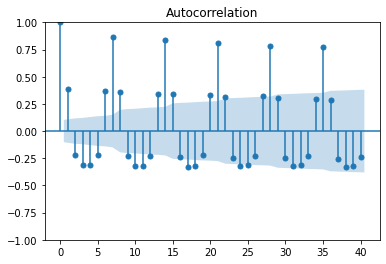

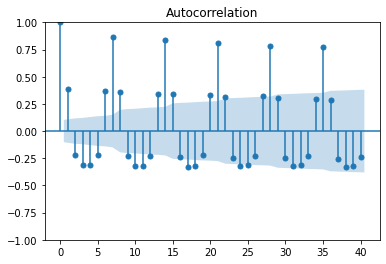

In [26]:
plot_acf(ts, lags=40)

From the Autocorrelation Function plot I can confirm that the time series has seasonality because of the wavy spikes, and that it has trend too seen as the spikes slowly somewhat decay over time.

In [27]:
stat = adfuller(ts)
print('p-value: %f' % stat[1])

p-value: 0.727455


The ADF test also points towards a non stationary time series seen as the p value is well above .05 . Now it's time to difference the data to be able to determine AR and MA terms.

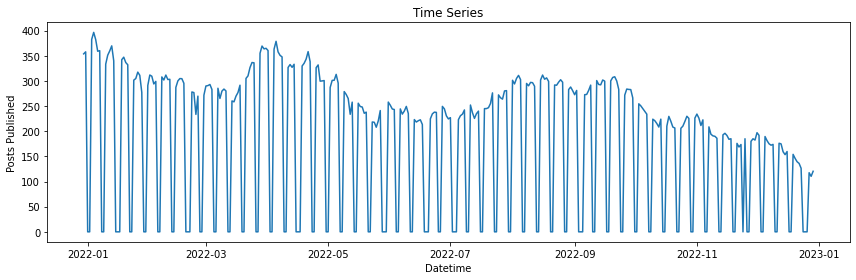

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(ts)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

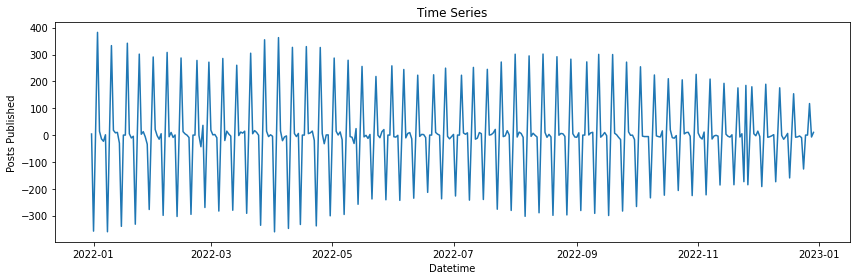

In [29]:
differenced = ts.diff()
plt.figure(figsize=(12, 4))
plt.plot(differenced)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Here I applied first differencing, it seems to have stablized the trend in the data, and now the seasonilty is very obvious, let's get rid of that too.

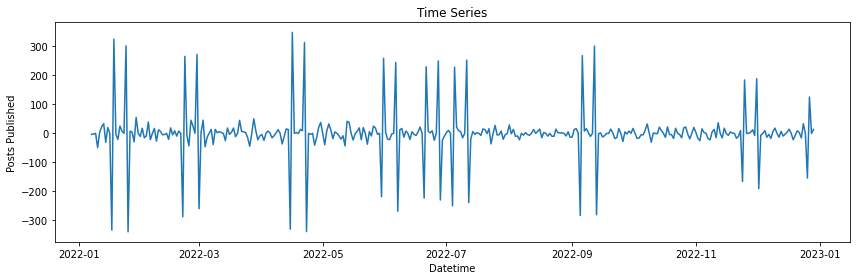

In [30]:
differenced_2 = differenced.diff(7)
plt.figure(figsize=(12, 4))
plt.plot(differenced_2)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

The result of the seasonal differencing is quite challenging because the DS doesn't show regular seasonality now, but rather highs and lows here and there without constant intervals, I'd like to mention here that I have tried seasonaly differencing the DS a second and third time but the results were the same as the first seasonal differencing, the up and down irregular patterns keep showing. So I will stop at this level of differencing and move on for now.

In [31]:
differenced_2 = differenced_2.dropna()

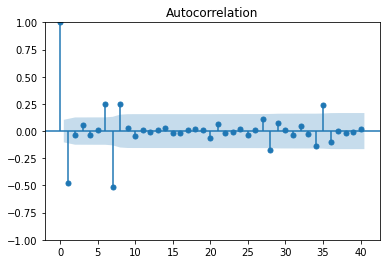

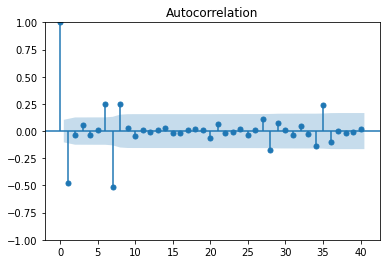

In [32]:
plot_acf(differenced_2, lags=40)

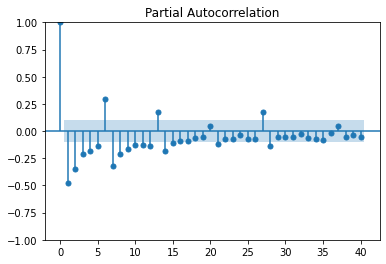

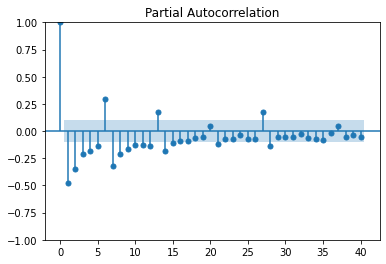

In [33]:
sm.graphics.tsa.plot_pacf(differenced_2, lags=40,method='ywm')

The ACF plot of the stationarised data cuts down quickly after the first lag suggestion that the series is stationarized, the first lag is also positive suggesting 1 AR term for the non seasonal part pof ARIMA. The PACF plot cutting off after the first lag is also a sign for using 1 AR terms. Now to the seasonal part of ARIMA, the ACF spike at lag 7 shows negative autocorrelation suggesting 1 MA term for the seasonal part of the model. 

In [34]:
sarima = sm.tsa.statespace.SARIMAX(train, order=(1,1,0), seasonal_order=(0,1,1,7))

In [35]:
fit = sarima.fit()

In [36]:
print(fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                Open   No. Observations:                  336
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1795.412
Date:                             Thu, 05 Jan 2023   AIC                           3596.824
Time:                                     19:26:11   BIC                           3608.203
Sample:                                 12-30-2021   HQIC                          3601.364
                                      - 11-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4291      0.025    -16.871      0.000      -0.479      -0.379
ma.S.L7       -0.8428      

The summary shows an AIC score bigger than the ETS model above, which means that the ETS model fits this time series better.

In [37]:
sarima = sm.tsa.statespace.SARIMAX(test, order=(1,1,0), seasonal_order=(0,1,1,7))

In [38]:
sarima_pred = sarima.fit().predict()

c:\users\imane\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [39]:
sarima_rmse =  mean_squared_error(test, sarima_pred, squared=False)
sarima_rmse

72.78924695963725

In [40]:
sarima_mae = mean_absolute_error(test, sarima_pred)
sarima_mae

40.010104937332166

The root mean error and mean absolte error are also higher for the SARIMA model.

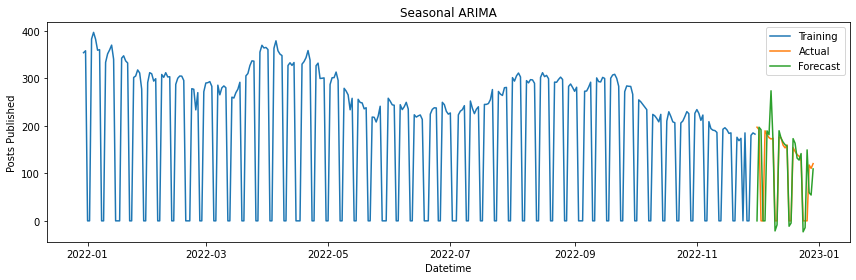

In [41]:
plot_forecast(sarima_pred, "Seasonal ARIMA")

Plotiing the results, they don't seem that far from the observed values, although the ETS model did a better job.

# Prophet model

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.

- Prophet is the facebooks’ open source tool for making time series predictions.

- Prophet decomposes time series data into trend, seasonality and holiday effect.

- Trend models non periodic changes in the time series data.

- Seasonality is caused due to the periodic changes like daily, weekly, or yearly seasonality.

- Holiday effect which occur on irregular schedules over a day or a period of days.

- Error terms is what is not explained by the model.

In [42]:
train = train.reset_index()
test = test.reset_index()

In [43]:
# renaming the columns
train = train.rename(columns={'Date': 'ds','Open': 'y'})
test = test.rename(columns={'Date': 'ds','Open': 'y'})

In [44]:
train

,ds,y
0,2021-12-30,353.776672
1,2021-12-31,357.813324
2,2022-01-01,0.000000
3,2022-01-02,0.000000
4,2022-01-03,382.583344
...,...,...
331,2022-11-26,0.000000
332,2022-11-27,0.000000
333,2022-11-28,179.960007
334,2022-11-29,184.990005


In [45]:
prophet = Prophet()

In [46]:
prophet.fit(train)

19:26:12 - cmdstanpy - INFO - Chain [1] start processing
19:26:12 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
ds = test.drop(columns="y")

In [48]:
prophet_preds = prophet.predict(ds)

In [49]:
prophet_pred = prophet_preds["yhat"]

In [50]:
prophet_rmse =  mean_squared_error(test.y, prophet_pred, squared=False)
prophet_rmse

73.90114571366685

In [51]:
prophet_mae = mean_absolute_error(test.y, prophet_pred)
prophet_mae

64.47584246310569

The Root Mean Error and Mean Absolute error are both higher i.e the Prophet model has done a poor job compared to ETS model and ARIMA.

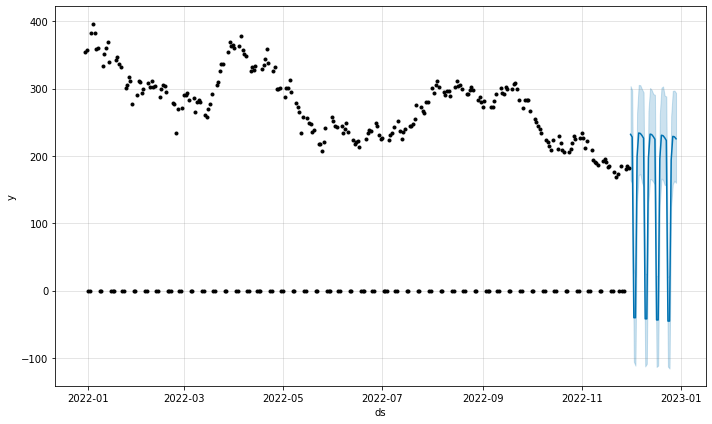

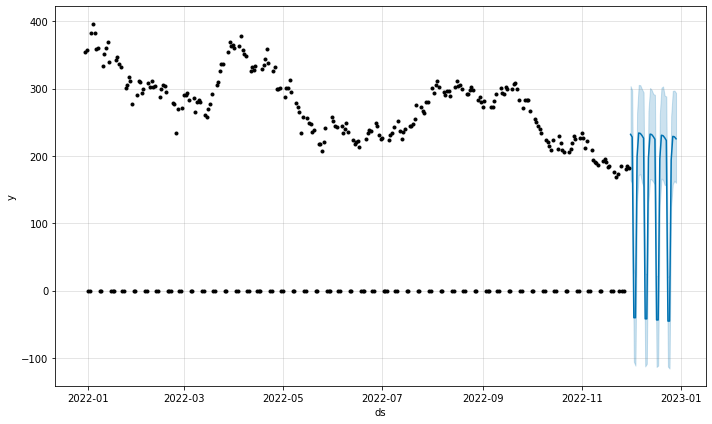

In [52]:
prophet.plot(prophet_preds)

The Plot above shows the forecasts of Prophet, they look similar to the actuall values but the ETS plot looks more aligned with the data.

# Comparing Models Performances

In [53]:
rmse = [ep_rmse, sarima_rmse, prophet_rmse]
mae = [ep_mae, sarima_mae, prophet_mae]
models = ["Exp Smoothing", "SARIMA", "Prophet"]

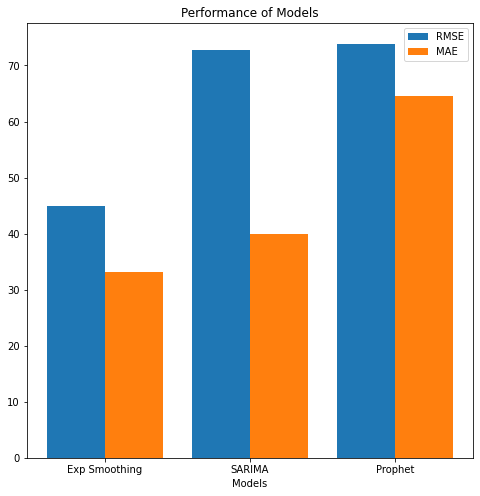

In [54]:
X_axis = np.arange(len(models))
plt.figure(figsize=(8, 8))  
plt.bar(X_axis - 0.2, rmse , 0.4, label = 'RMSE')
plt.bar(X_axis + 0.2, mae, 0.4, label = 'MAE')
  
plt.xticks(X_axis, models)
plt.xlabel("Models")
plt.title("Performance of Models")
plt.legend()

The bar plot above shows the performance of the three models I used in this notebook. The lowest errors are those of the ETS model Holt Winter's explonential smoothing, add to that the Akaike Information Criterion that is at its lowest for the same model. I therefore prefer to use holt Winters Seasonal method to forecast for this dataset.

# Making forecasts

First let's creates timestamps for the next 30 that I want to forecast.

In [55]:
future = pd.date_range(start="2023-01-01",end="2023-01-31").tolist()

In [56]:
future = pd.DataFrame(future)

In [57]:
ep = ExponentialSmoothing(ts, seasonal_periods=7, trend='add', seasonal='add').fit()

In [58]:
forecast = ep.forecast(len(test))

In [59]:
forecast = pd.DataFrame(forecast)

In [60]:
final = ts.append(forecast)

C:\Users\imane\AppData\Local\Temp/ipykernel_13416/3143238598.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = ts.append(forecast)


In [61]:
final = final.fillna(0)
        

In [62]:
final = final.sum(axis =1)

In [65]:
final = pd.DataFrame(final)

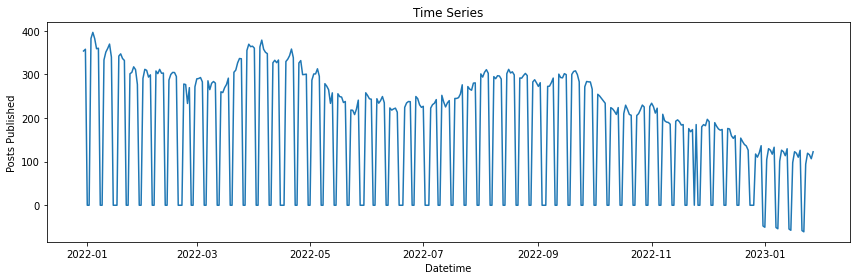

In [67]:
plt.figure(figsize=(12, 4))
plt.plot(final)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

In this part I used the entire time series for training, and forecasted the following month of January 2023, the results show  gradually decreasing opening prices of Tesla stock options.

# Conclusion

In this notebook I have gone throught the last year of Tesla's stock prices to understand that they have a downtrend over time and a seasonality that decreases over time. With the help of three time series forecasting models (ETS, SARIMA and Prophet) I was able to make predictions and compare my results cross model. For my ETS model I used and addutive method for both trend and seasonality, for the SARIMA model I used some AR and MA terms plus the differencing terms and with Prophet I accounted for the holidays seasonality in the data. The results lead me towards my ETS model : Holt Winter's seasonal trend which yielded the lowest errors and lowest AIC score. I then used my tuned ETS model to make forecasts of January 2023 which indicate yet a loss in the value of Tesla's stock options.

# References

https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet

https://github.com/imane-ayouni/Time-Series-Forecast-Medium-Daily-Posts-Forecast/blob/main/Time%20Series%20Forecast%20Medium%20Daily%20Posts%20Forecast.ipynb

